In [1]:
# %%
from my_functions import *

# %%
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

In [2]:
"""
Here I'm going to use LVL1 muons
"""

muon_eta_all=MuonTree_ZeroBias["LVL1Muon_eta"].array()
muon_phi_all=MuonTree_ZeroBias["LVL1Muon_phi"].array()

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res1=muon_isolation_all_events(MuonTree_ZeroBias,muon_eta_all,muon_phi_all,0.4,[0,5000],500)
# %%
muon_eta_all=MuonTree_Zmumu["LVL1Muon_eta"].array()
muon_phi_all=MuonTree_Zmumu["LVL1Muon_phi"].array()

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res2=res=muon_isolation_all_events(MuonTree_Zmumu,muon_eta_all,muon_phi_all,0.4,[0,1000],100)

# %%
data1=ak.flatten(res1)
data2=ak.flatten(res2)

colors=['b','r']
labels=[r"Zero Bias LVL1 muons",r"Z $\longrightarrow \mu \mu$ LVL1 muons"]

coolplot([data1,data2],np.linspace(0,30000,25),colors,labels,"Transverse energy (MeV)","Counts","Energy histogram isolated muons ATLAS detector")

print(r"Some of the isolated energies for Z to mumu LVL1 muons are:", res2[0] ,"and", res[1], ". The mean "
"value is", ak.mean(res2), "MeV")


Non-empty elements: 15495


 60%|██████    | 6/10 [00:05<00:03,  1.08it/s]


KeyboardInterrupt: 

Non-empty elements: 113235


100%|██████████| 4/4 [00:19<00:00,  4.84s/it]


Non-empty elements: 200000


100%|██████████| 2/2 [01:25<00:00, 42.83s/it]


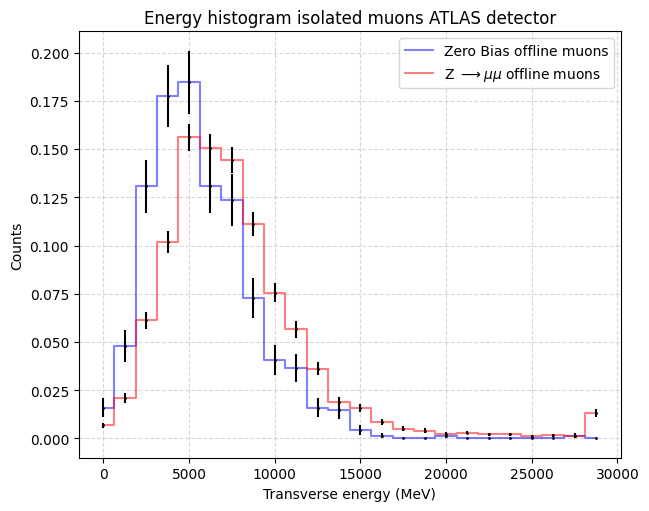

Some of the isolated energies for Z to mumu offline muons are: [np.float32(6650.0), np.float32(6225.0)] and [np.float32(4750.0), np.float32(4775.0)] . The mean value is 8482.743067156698 MeV


In [ ]:

"""
Here I want to use offline muons
"""

muon_eta_all=MuonTree_ZeroBias["muon_eta"].array()
muon_phi_all=MuonTree_ZeroBias["muon_phi"].array()

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res1=muon_isolation_all_events(MuonTree_ZeroBias,muon_eta_all,muon_phi_all,0.4,[12000,14000],500)
# %%
muon_eta_all=MuonTree_Zmumu["muon_eta"].array()
muon_phi_all=MuonTree_Zmumu["muon_phi"].array()

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res2=res=muon_isolation_all_events(MuonTree_Zmumu,muon_eta_all,muon_phi_all,0.4,[0,1000],500)

data1=ak.flatten(res1)
data2=ak.flatten(res2)

colors=['b','r']
labels=[r"Zero Bias offline muons",r"Z $\longrightarrow \mu \mu$ offline muons"]

coolplot([data1,data2],np.linspace(0,30000,25),colors,labels,"Transverse energy (MeV)","Counts","Energy histogram isolated muons ATLAS detector")

print(r"Some of the isolated energies for Z to mumu offline muons are:", res2[0] ,"and", res[1], ". The mean "
"value is", ak.mean(res2), "MeV")

############################################################


Non-empty elements: 113235


100%|██████████| 4/4 [00:22<00:00,  5.61s/it]


Only 21.265 % of the data has been selected
Only 21.265 % of the data has been selected
Non-empty elements: 42530


100%|██████████| 2/2 [00:58<00:00, 29.17s/it]


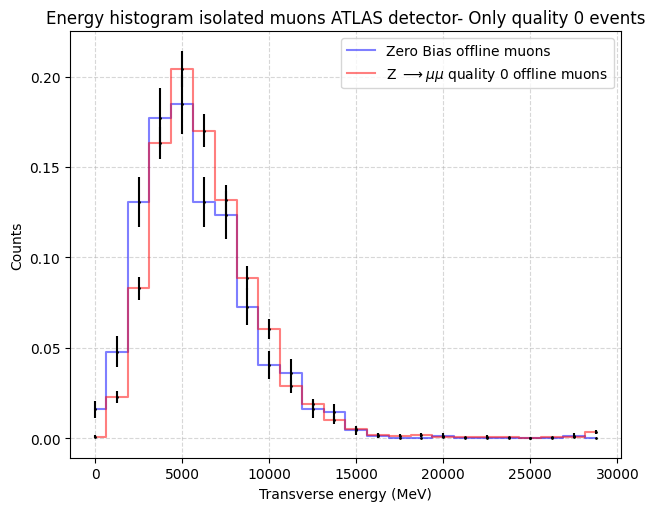

Some of the isolated energies for Z to mumu quality 0 offline muons are: [np.float32(6650.0), np.float32(6225.0)] and [np.float32(4750.0), np.float32(4775.0)] . The mean value is 7062.493821057835 MeV


In [ ]:
"""
Here I want to plot the same thing but I'm going to select only quality 0 data for the Z->mu mu events
"""

muon_eta_all=MuonTree_ZeroBias["muon_eta"].array()
muon_phi_all=MuonTree_ZeroBias["muon_phi"].array()

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res1=muon_isolation_all_events(MuonTree_ZeroBias,muon_eta_all,muon_phi_all,0.4,[12000,14000],500)

"""
Now select only quality 0 events for the Z mumu data
"""

muon_eta_all=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)
muon_phi_all=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)

non_empty_count = ak.sum(ak.num(muon_eta_all) > 0)
print("Non-empty elements:", non_empty_count)

res2=res=muon_isolation_all_events(MuonTree_Zmumu,muon_eta_all,muon_phi_all,0.4,[0,1000],500)

data1=ak.flatten(res1)
data2=ak.flatten(res2)

colors=['b','r']
labels=[r"Zero Bias offline muons",r"Z $\longrightarrow \mu \mu$ quality 0 offline muons"]

coolplot([data1,data2],np.linspace(0,30000,25),colors,labels,"Transverse energy (MeV)","Counts"
,"Energy histogram isolated muons ATLAS detector- Only quality 0 events")

print(r"Some of the isolated energies for Z to mumu quality 0 offline muons are:", res2[0] ,"and", res[1], ". The mean "
"value is", ak.mean(res2), "MeV")

In [ ]:
"""
In this part I'm going to plot the ratio of isolated energy / transverse energy (or approximately, pt)

Since I'm not using the full dataset, I must select only the respective events for pt1 and pt2, otherwise the lenghts will no be the same
and the data will not match. Also, the length of the events may not be the same, due to the delta r threshold, that rules out some events.
To make sure that I'm dividing elements with the same shape, I create the boolean mask
"""
#for zero bias i'm using events 12000 to 14000
pt1=MuonTree_ZeroBias["muon_pt"].array()[12000:14000]
#for z mumu i'm using events 0 to 1000
pt2=MuonTree_Zmumu["muon_pt"].array()[0:1000]

#make res1 and res2 awkard arrays and not lists
res1=ak.Array(res1)
res2=ak.Array(res2)
mask = (ak.num(pt1) == ak.num(res1))

res1_mask=res1[mask]
pt1_mask=pt1[mask]

data1=res1_mask/pt1_mask

mask = (ak.num(pt2) == ak.num(res2))
res2_mask=res2[mask]
pt2_mask=pt2[mask]

data2=res2_mask/pt2_mask
data2

data1=ak.flatten(data1)
data2=ak.flatten(data2)